### In the cell below, change PATH in os.chdir(PATH) to your local alignment folder with intersect.bam within it.

In [2]:
import os
os.chdir("/gpfs/group/jin/Cassie/250708_iSeq/vs_analysis_Dual/Lib9/S14")
print(os.getcwd())

/gpfs/group/jin/Cassie/250708_iSeq/vs_analysis_Dual/Lib9/S14


In [3]:
%%bash
samtools view intersect.bam | cut -f1 | sort -u > readnames.txt

module load seqtk
seqtk subseq /gpfs/home/asun/jin_lab/yap/raw_data/R/TEST-R-1-A1_ii1_L003_R1_ii2.fq.gz readnames.txt > grna_r1.fq
seqtk subseq /gpfs/home/asun/jin_lab/yap/raw_data/R/TEST-R-1-A1_ii1_L003_R2_ii2.fq.gz readnames.txt > grna_r2.fq

bash: line 1: readnames.txt: Permission denied
[E::hts_open_format] Failed to open file "intersect.bam" : No such file or directory
samtools view: failed to open "intersect.bam" for reading: No such file or directory
bash: line 4: grna_r1.fq: Permission denied
bash: line 5: grna_r2.fq: Permission denied


CalledProcessError: Command 'b'samtools view intersect.bam | cut -f1 | sort -u > readnames.txt\n\nmodule load seqtk\nseqtk subseq /gpfs/home/asun/jin_lab/yap/raw_data/R/TEST-R-1-A1_ii1_L003_R1_ii2.fq.gz readnames.txt > grna_r1.fq\nseqtk subseq /gpfs/home/asun/jin_lab/yap/raw_data/R/TEST-R-1-A1_ii1_L003_R2_ii2.fq.gz readnames.txt > grna_r2.fq\n'' returned non-zero exit status 1.

In [4]:
import pandas as pd
import numpy as np
import subprocess
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from cemba_data.utilities import get_configuration

import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import Normalize


In [5]:
def plot_on_plate(data,
                  hue,
                  groupby,
                  ncols=4,
                  plate_base=384,
                  figsize_scale=1,
                  row='Row384',
                  col='Col384',
                  vmin=0,
                  vmax=1,
                  aggregation_func=None):
    """
    Plot metadata into 384 or 96 plate view (heatmap)
    Parameters
    ----------
    data
        dataframe contain plate postion and metric used for color
    hue
        int/float column name used as hue
    groupby
        groupby column, typically groupby plate id column(s) to plot each plate separately
    ncols
        number of column for axes, nrows will be calculated accordingly
    plate_base
        {384, 96} size of the plate view
    figsize_scale
        scale of figure size
    row
        column name for rows
    col
        column name for columns
    vmin
        cmap vmin
    vmax
        cmap vmax
    aggregation_func
        apply to reduce rows after groupby if the row is not unique
    """

    if plate_base == 384:
        plate_nrows, plate_ncols = 16, 24

    elif plate_base == 96:
        plate_nrows, plate_ncols = 8, 12
    else:
        raise ValueError(f'Plate base {plate_base} unknown')

    plot_data_list = []
    plate_names = []
    for plate, sub_df in data.groupby(groupby):
        # check if plate base are duplicated
        duplicated = sub_df[[row, col]].duplicated().sum() != 0
        if duplicated:
            if aggregation_func is None:
                raise ValueError(
                    'Row after groupby is not unique, aggregation_func can not be None'
                )
            plot_data = sub_df.groupby([row,
                                        col])[[hue, 'assign_ident']].apply(aggregation_func)
        else:
            plot_data = sub_df.set_index([row, col])[[hue, 'assign_ident']]
        # reindex, missing value will keep as NA
        full_index = pd.MultiIndex.from_tuples([(i, j)
                                                for i in range(plate_nrows)
                                                for j in range(plate_ncols)],
                                               names=[row, col])
        plot_data = plot_data.reindex(full_index).reset_index()
        plot_data_list.append(plot_data)
        if isinstance(plate, str):
            plate_names.append(plate)
        else:
            plate_names.append('\n'.join(plate))

    ncols = min(len(plot_data_list), ncols)
    nrows = int(np.ceil(len(plot_data_list) / ncols))
    cbar_frac = 0.06

    fig = plt.figure(figsize=((6.2 * ncols) * (1 + cbar_frac) * figsize_scale,
                              4 * nrows * figsize_scale))
    gs = fig.add_gridspec(nrows, ncols, wspace=0.1)
    cmap = copy.copy(mpl.cm.get_cmap("viridis"))
    cmap.set_under(color='#440154')
    cmap.set_over(color='#FDE725')
    cmap.set_bad(color='#FFFFFF')
    cnorm = Normalize(vmin, vmax)

    for i, (name, data) in enumerate(zip(plate_names, plot_data_list)):
        ax_row = i // ncols
        ax_col = i % ncols

        ax = fig.add_subplot(gs[ax_row, ax_col])

        # Get edgecolor mapping for assign_identity
        identities = sorted(data['assign_ident'].dropna().unique())
        edgecolor_palette = dict(zip(identities, plt.cm.tab10.colors))  # or use your own palette

        # Merge identity into plate-specific data (if not already included)
        if 'assign_ident' not in data.columns:
            raise ValueError("'assign_ident' column is missing from input data.")

        # Match identity to each point
        well_identity = data.set_index([row, col]).reindex(
            pd.MultiIndex.from_tuples(list(zip(data[row], data[col])))).reset_index()['assign_ident']

        edge_colors = []
        linewidths = []

        for identity in well_identity:
            color = edgecolor_palette.get(identity, 'lightgray') if pd.notna(identity) else 'lightgray'
            edge_colors.append(color)
            linewidths.append(2 if color != 'lightgray' else 1)  # thicker ring if not lightgray

        ax.scatter(
            x=data[col],
            y=data[row],
            c=[cmap(cnorm(v)) for v in data[hue]],
            s=100,
            edgecolors=edge_colors,
            linewidths=linewidths
        )

        ax.set(title=name,
               ylabel='',
               ylim=(plate_nrows, -1),
               yticks=list(range(16)),
               yticklabels=[chr(i + 65) for i in range(0, 16)],
               xlabel='',
               xticks=range(24),
               xticklabels=range(1, 25))
        if i == 0 and len(edgecolor_palette) > 0:
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='white',
                    edgecolor=edgecolor_palette[ident],
                    linewidth=2,
                    label=ident)
                for ident in identities
            ]
            ax.legend(
                handles=legend_elements,
                title='assign_ident',
                bbox_to_anchor=(1.05, 1.15),
                loc='upper left',
                fontsize=8,
                title_fontsize=9,
            )
        ax.xaxis.set_tick_params(labelsize=8)
        ax.yaxis.set_tick_params(labelsize=8)
        ax.xaxis.tick_top()
    fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap),
                 ax=fig.axes,
                 shrink=0.6,
                 fraction=cbar_frac,
                 label=hue)
    return fig, plate_names, plot_data_list

### In the cell below, change output_dir to the path that you demultiplexed your YAP pipeline in.

In [6]:
output_dir = ''
plate_col = 'Plate'
color_quantile = (0.025, 0.975)

# Parameters
output_dir = "/gpfs/group/jin/asun/yap/pipeline2_yap_s10/yap_demultiplex"
output_dir = pathlib.Path(output_dir)
mapping_summary = pd.read_csv(output_dir / 'stats/MappingSummary.csv.gz', index_col=0)
config = get_configuration(output_dir / 'mapping_config.ini')

In [7]:
def visualize_local(data, hue):
    vmax = data[hue].max()
    fig2, plate_names, plate_datas = plot_on_plate(
        data=data,
        hue=hue,
        groupby=plate_col,
        vmin=0,
        vmax=vmax,
        aggregation_func=lambda i: i.mean())
    return

In [8]:
# Function to reverse complement if RC column is "RC"
def conditional_reverse_complement(row):
    if row["RC"] == "RC":
        return str(Seq(row["SEQ"]).reverse_complement())
    return row["SEQ"]  # Keep the sequence unchanged if not "RC"

# Load BAM into DataFrame
sam_output = subprocess.run(["samtools", "view", "/gpfs/group/jin/Cassie/250708_iSeq/vs_analysis_Dual/Lib9/S14/vsS14D_intersect.bam"], capture_output=True, text=True)
sam_lines = sam_output.stdout.strip().split("\n")

# Convert SAM to DataFrame
columns = ["QNAME", "FLAG", "RNAME", "POS", "MAPQ", "CIGAR", "RNEXT", "PNEXT", "TLEN", "SEQ", "QUAL"]
data = [line.split("\t")[:11] for line in sam_lines]
df = pd.DataFrame(data, columns=columns)

# Convert FLAG to numeric
df["FLAG"] = pd.to_numeric(df["FLAG"])
df["RC"] = df["FLAG"].apply(lambda x: "RC" if x & 16 else "FORWARD")

rp_indices = pd.read_csv("/gpfs/home/asun/jin_lab/yap/raw_data/384RPIndexes.csv")
rp_indices = rp_indices.rename(columns={"RP Index": "RP_INDEX", "Position": "WELL"})   

# Apply the function to create the TRUE_SEQ column
df["TRUE_SEQ"] = df.apply(conditional_reverse_complement, axis=1)

df["RP_INDEX"] = df["TRUE_SEQ"].apply(lambda x: x[:8])

# Assign read type
df["READ_TYPE"] = df["FLAG"].apply(lambda x: "READ_1" if x & 64 else ("READ_2" if x & 128 else "UNPAIRED"))

df["READ_1"] = ""

readnames = df.loc[(df["READ_TYPE"] == "READ_2"), "QNAME"].tolist()

with open("vsS14D_grna_r1.fq", "r") as fq:
    while True:
        header = fq.readline().strip()  
        seq = fq.readline().strip()     
        fq.readline()                   
        fq.readline()                   
        
        if not header:
            break  # End of file
        
        qname = header.lstrip("@")

        if qname in df["QNAME"].values:
            first_8_bp = seq[:8]  # Extract the first 8 bases
            df.loc[df["QNAME"] == qname, "READ_1"] = seq
            df.loc[df["QNAME"] == qname, "RP_INDEX"] = first_8_bp


df = df.merge(rp_indices, on=["RP_INDEX"], how="left")
df_filtered = df.drop_duplicates(subset='QNAME', keep='first')
len(df_filtered)

result = (
    df_filtered.groupby(['WELL', 'RNAME'])
    .size()
    .unstack(fill_value=0)
)

# This gives you the desired result
result = result.astype(int)
result = result.reset_index()
result

RNAME,WELL,Dnmt1_g1,Safe_g1
0,C1,1,0
1,D1,0,15
2,F1,0,13
3,G1,0,2
4,H1,12,4
5,H3,1,0
6,I1,0,1


In [9]:
len(df_filtered)


51

In [14]:
# Step 1: Merge and clean
merged_local_mapping = pd.merge(mapping_summary, result, how="left", left_on="RandomIndex", right_on="WELL")
merged_local_mapping = merged_local_mapping.drop(columns='WELL')
merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].fillna(0).astype(int)

# --- Dynamically extract gene names ---
guide_cols = [col for col in result.columns if col.endswith('_g1') or col.endswith('_g2')]
genes = sorted(set(col.rsplit('_', 1)[0] for col in guide_cols))  # e.g., ['Dnmt3a', 'Foxg1', 'Safe']

# Step 2: Compute total counts per gene
def safe_sum(df, col1, col2):
    return df.get(col1, 0) + df.get(col2, 0)

for gene in genes:
    col1 = f"{gene}_g1"
    col2 = f"{gene}_g2"
    merged_local_mapping[f"{gene}_total"] = safe_sum(merged_local_mapping, col1, col2)

# Step 3: Compute overall total and assign identity
gene_total_cols = [f"{gene}_total" for gene in genes]
merged_local_mapping["Total_grna"] = merged_local_mapping[gene_total_cols].sum(axis=1)

merged_local_mapping['assign_ident'] = merged_local_mapping[gene_total_cols].idxmax(axis=1)

## change threshold to whatever minimum grna you want
threshold=5
merged_local_mapping.loc[merged_local_mapping['Total_grna'] < threshold, 'Total_grna'] = 0
merged_local_mapping.loc[merged_local_mapping["Total_grna"] == 0, 'assign_ident'] = np.nan

# Step 4: Validate assign_ident and extract value from correct column
merged_local_mapping = merged_local_mapping[merged_local_mapping['assign_ident'].isin(gene_total_cols)]
merged_local_mapping['Total_grna'] = merged_local_mapping.to_numpy()[
    np.arange(len(merged_local_mapping)),
    merged_local_mapping.columns.get_indexer(merged_local_mapping['assign_ident'])
]

# Step 5: Strip '_total' from assign_ident
merged_local_mapping['assign_ident'] = merged_local_mapping['assign_ident'].str.replace('_total', '', regex=False)

# Step 6: Replace 0s with NaNs
merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].replace(0, np.nan)
merged_local_mapping["Total_grna"] = merged_local_mapping["Total_grna"].replace(0, np.nan)
for gene in genes:
    merged_local_mapping[f"{gene}_total"] = merged_local_mapping[f"{gene}_total"].replace(0, np.nan)


# Final result
merged_local_mapping

,Plate,PCRIndex,MultiplexGroup,RandomIndex,Col384,Row384,Plate.1,PCRIndex.1,MultiplexGroup.1,RandomIndex.1,...,GenesDetected,DNAReadsYield,RNAReadsYield,RNA/(DNA+RNA),Dnmt1_g1,Safe_g1,Dnmt1_total,Safe_total,Total_grna,assign_ident
12,S_10,A1,1,D1,0,3,S_10,A1,1,D1,...,1319,0.000012,0.018617,1.712952,NaN,15,NaN,15,15,Safe
20,S_10,A1,1,F1,0,5,S_10,A1,1,F1,...,1110,0.000019,0.043730,1.734582,NaN,13,NaN,13,13,Safe
28,S_10,A1,1,H1,0,7,S_10,A1,1,H1,...,1580,0.005394,0.060345,1.480583,12.0,4,12.0,4,12,Dnmt1


In [34]:
merged_local_mapping.to_csv("S10_metadata_matrix.csv", index=True)

### In the cell below, change hue to one of the following options depending on what you want to visualize: "Total_grna", "Foxg1_g1", "Foxg1_g2", "Dnmt3a_g1", "Dnmt3a_g2", "Safe_g1", "Safe_g2".

/tmp/ipykernel_5463/338111938.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(mpl.cm.get_cmap("viridis"))
/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


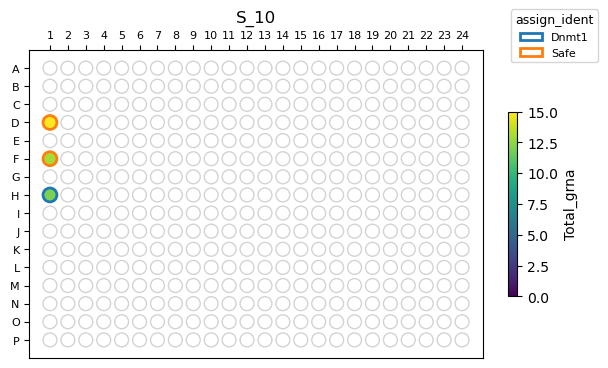

In [15]:
visualize_local(merged_local_mapping, hue="Total_grna")
